In [1]:
from datasets import load_dataset
import tiktoken
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import get_dataset_config_names, load_dataset
from transformers import AutoTokenizer

## Introduction: The bvv241* Tokenizer Architecture

This work introduces the **bvv241** tokenizer family, a set of open-source multilingual tokenization schemes designed to maximize transparency, Unicode coverage, and extensibility. All implementations are available on HuggingFace for public access and reproducibility:

- [bvv241-2-3](https://huggingface.co/Bochkov/bvv241-2-3)
- [bvv241-max](https://huggingface.co/Bochkov/bvv241-max)
- [bvv241-nemo](https://huggingface.co/Bochkov/bvv241-nemo)
- [bvv241-abs](https://huggingface.co/Bochkov/bvv241-abs)

The core approach is based on bijective mapping of Unicode codepoints to individual tokens, whenever possible, ensuring a 1:1 relationship between characters and tokens across a wide range of scripts. Reserved, surrogate, and private Unicode ranges are systematically exploited to store custom and multi-character tokens, allowing for efficient representation of commonly occurring substrings and entire words—particularly beneficial for high-frequency terms shared across models and languages.

The tokenizer’s hybrid design draws from frequent multi-character patterns identified in top-performing, state-of-the-art models: approximately 19,000 such tokens are incorporated. This structure enables robust handling of diverse languages and scripts, mitigating the fragmentation common in byte-pair encoding (BPE) and unigram tokenizers—especially for underrepresented scripts and code-mixed text.

All bvv241* tokenizer variants, vocabularies, and evaluation tools are publicly available, promoting transparency and collaborative research in multilingual NLP scenarios.

Demonstration Variant: bvv241-nemo
- [bvv241-nemo](https://huggingface.co/Bochkov/bvv241-nemo)

The bvv241-nemo variant is provided as a demonstration of the flexibility of the proposed methodology. While the underlying Unicode-centric mapping scheme is applicable to any tokenizer, bvv241-nemo specifically replicates the vocabulary, token structure, and exact token enumeration of the SOTA [Mistral Nemo tokenizer](https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407), using its public vocabulary files as a template. This showcases how the approach can serve as a drop-in replacement or augmentation for existing BPE or unigram schemes.

Furthermore, since all token indices and their corresponding Unicode/codepoint representations are deterministic and exhaustively specified, this methodology enables the direct creation of a pre-initialized embedding matrix of shape vocab_size × n_embed. Such a matrix can be either used as a fixed (non-trainable) embedding or as a high-quality cold start, reducing the need for extensive embedding pre-training.

The code and trained vocabularies for bvv241-nemo are publicly available for reproducibility and to foster further experimentation.

## The code below demonstrates how to benchmark tokenizer efficiency and generate comparative visualizations for different languages:

In [2]:
languages =     ["en", "ru", "fr", "de", "zh", "he", "it", "es", "ar", "pt", "ko", "hu", "sa", "la", "ja", "el",     "sv", "nl", "pl", "vi", "fa", "no", "tr", "fi", "cs", "hy", "da", "bn", "az", "ka", "hi", "id"]

lang_name_map = {
    "en": "English",
    "ru": "Russian",
    "fr": "French",
    "de": "German",
    "zh": "Chinese",
    "he": "Hebrew",
    "it": "Italian",
    "es": "Spanish",
    "ar": "Arabic",
    "pt": "Portuguese",
    "ko": "Korean",
    "hu": "Hungarian",
    "sa": "Sanskrit",
    "la": "Latin",
    "ja": "Japanese",
    "el": "Greek",

    "sv": "Swedish",
    "nl": "Dutch",
    "pl": "Polish",
    "vi": "Vietnamese",
    "fa": "Persian",
    "no": "Norwegian",
    "tr": "Turkish",
    "fi": "Finnish",
    "cs": "Czech",
    "hy": "Armenian",
    "da": "Danish",
    "bn": "Bangla",
    "az": "Azerbaijani",
    "ka": "Georgian",
    "hi": "Hindi",
    "id": "Indonesian"
}

In [3]:
tiktoken_gpt2_tok = tiktoken.get_encoding("gpt2")
tiktoken_cl100k_tok = tiktoken.get_encoding("cl100k_base")

hf_tokenizers = {
    "bvv241-2-3":  AutoTokenizer.from_pretrained("Bochkov/bvv241-2-3"),                             #vocab_size 65536
    #"bvv241-abs"=="bvv241-max":  AutoTokenizer.from_pretrained("Bochkov/bvv241-abs"),              #vocab_size 131072
    "bvv241-nemo": AutoTokenizer.from_pretrained("Bochkov/bvv241-nemo"),                            #vocab_size 131072
    "bvv241-max":  AutoTokenizer.from_pretrained("Bochkov/bvv241-max"),                             #vocab_size 131072
    "Mistral":     AutoTokenizer.from_pretrained('mistralai/Mistral-Nemo-Instruct-2407'),           #vocab_size 131072
    "Qwen":        AutoTokenizer.from_pretrained("Qwen/QwQ-32B", trust_remote_code=True),           #vocab_size 152064
    "DeepSeek-R1": AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1", trust_remote_code=True),#vocab_size 129280
}

In [4]:
wikipedia_dataset_id = "wikimedia/wikipedia"
wikisource_dataset_id = "wikimedia/wikisource"

In [5]:
configs_wikipedia = get_dataset_config_names(wikipedia_dataset_id)

In [6]:
configs_wikisource = get_dataset_config_names(wikisource_dataset_id)

In [7]:
def analyze_tokenizer(texts, tokenizer, tokenizer_name="unknown", is_tiktoken=False):
    char_counts = []
    token_counts = []
    for text in texts:
        chars = len(text)
        tokens = tokenizer.encode(text) if is_tiktoken else tokenizer.encode(text, add_special_tokens=False)
        num_tokens = len(tokens) if isinstance(tokens, list) else len(tokens["input_ids"])
        if num_tokens == 0:
            continue
        char_counts.append(chars)
        token_counts.append(num_tokens)
    ratio = np.array(char_counts) / np.array(token_counts)
    return ratio.mean(), ratio.std()

In [8]:
top_pct = 0.05 # 5% of wikipedia & wikisource:

In [ ]:
results = []

for lang in languages:
    try:
        texts = []
        try:
            configs = configs_wikipedia 
            latest_config = sorted([c for c in configs if c.endswith(f".{lang}")])[-1]
            ds = load_dataset(wikipedia_dataset_id, latest_config, split="train") 
            total_len = len(ds)
            sample_size = int(total_len * top_pct)
            ds_sub = ds.shuffle(seed=42).select(range(sample_size))
            print('lang=', lang, ' (', lang_name_map[lang], ') len(ds wikipedia)  =',len(ds))
            texts = [x['text'] for x in ds_sub]
        except Exception as e:
            print(f"❌ Error processing wikipedia_dataset_id, language '{lang}': {e}")
            pass

        if lang != 'ka':
            try:
                configs = configs_wikisource 
                latest_config = sorted([c for c in configs if c.endswith(f".{lang}")])[-1]
                ds = load_dataset(wikisource_dataset_id, latest_config, split="train") 
                total_len = len(ds)
                sample_size = int(total_len * top_pct)
                ds_sub = ds.shuffle(seed=42).select(range(sample_size))
                print('lang=', lang, ' (', lang_name_map[lang], ') len(ds wikisource) =',len(ds))
                texts = texts + [x['text'] for x in ds_sub]
            except Exception as e:
                print(f"❌ Error processing wikisource_dataset_id, language '{lang}': {e}")
                pass

        # GPT-2 (tiktoken)
        avg, std = analyze_tokenizer(texts, tiktoken_gpt2_tok, "GPT-2", is_tiktoken=True)
        results.append({"Language": lang, "Tokenizer": "GPT-2", "MeanCharsPerToken": avg, "Std": std})
        print({"Language": lang, "Tokenizer": "GPT-2", "MeanCharsPerToken": avg, "Std": std})

        # GPT-4 (cl100k)
        avg, std = analyze_tokenizer(texts, tiktoken_cl100k_tok, "GPT-4", is_tiktoken=True)
        results.append({"Language": lang, "Tokenizer": "GPT-4", "MeanCharsPerToken": avg, "Std": std})
        print({"Language": lang, "Tokenizer": "GPT-4", "MeanCharsPerToken": avg, "Std": std})

        for name, tok in hf_tokenizers.items():
            avg, std = analyze_tokenizer(texts, tok, name, is_tiktoken=False)
            results.append({"Language": lang, "Tokenizer": name, "MeanCharsPerToken": avg, "Std": std})
            print({"Language": lang, "Tokenizer": name, "MeanCharsPerToken": avg, "Std": std})
        
    except Exception as e:
        print(f"❌ Error processing language '{lang}': {e}")
        continue

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

lang= en  ( English ) len(ds wikipedia)  = 6407814
lang= en  ( English ) len(ds wikisource) = 208279


In [ ]:
df = pd.DataFrame(results)

pd.set_option('display.max_colwidth', None)

df_pivot = df.pivot(index="Language", columns="Tokenizer", values="MeanCharsPerToken")

df["LanguageName"] = df["Language"].map(lang_name_map)

df_pivot = df.pivot_table(index="LanguageName", columns="Tokenizer", values="MeanCharsPerToken")

df_pivot = df_pivot.sort_index()

df_pivot.to_csv("_tokenizer-benchmarking.csv")

df_pivot.round(2)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_pivot = pd.read_csv('_tokenizer-benchmarking.csv', index_col=0)

plt.figure(figsize=(20, 9))
sns.set(style="whitegrid")

selected_tokenizers = [
    "DeepSeek-R1", "GPT-2", "GPT-4", "Mistral", "Qwen", 
    "bvv241-2-3", "bvv241-max", "bvv241-nemo"
]

df_long = df_pivot[selected_tokenizers].reset_index().melt(
    id_vars='LanguageName', var_name='Tokenizer', value_name='Chars per Token'
)

<Figure size 2000x900 with 0 Axes>

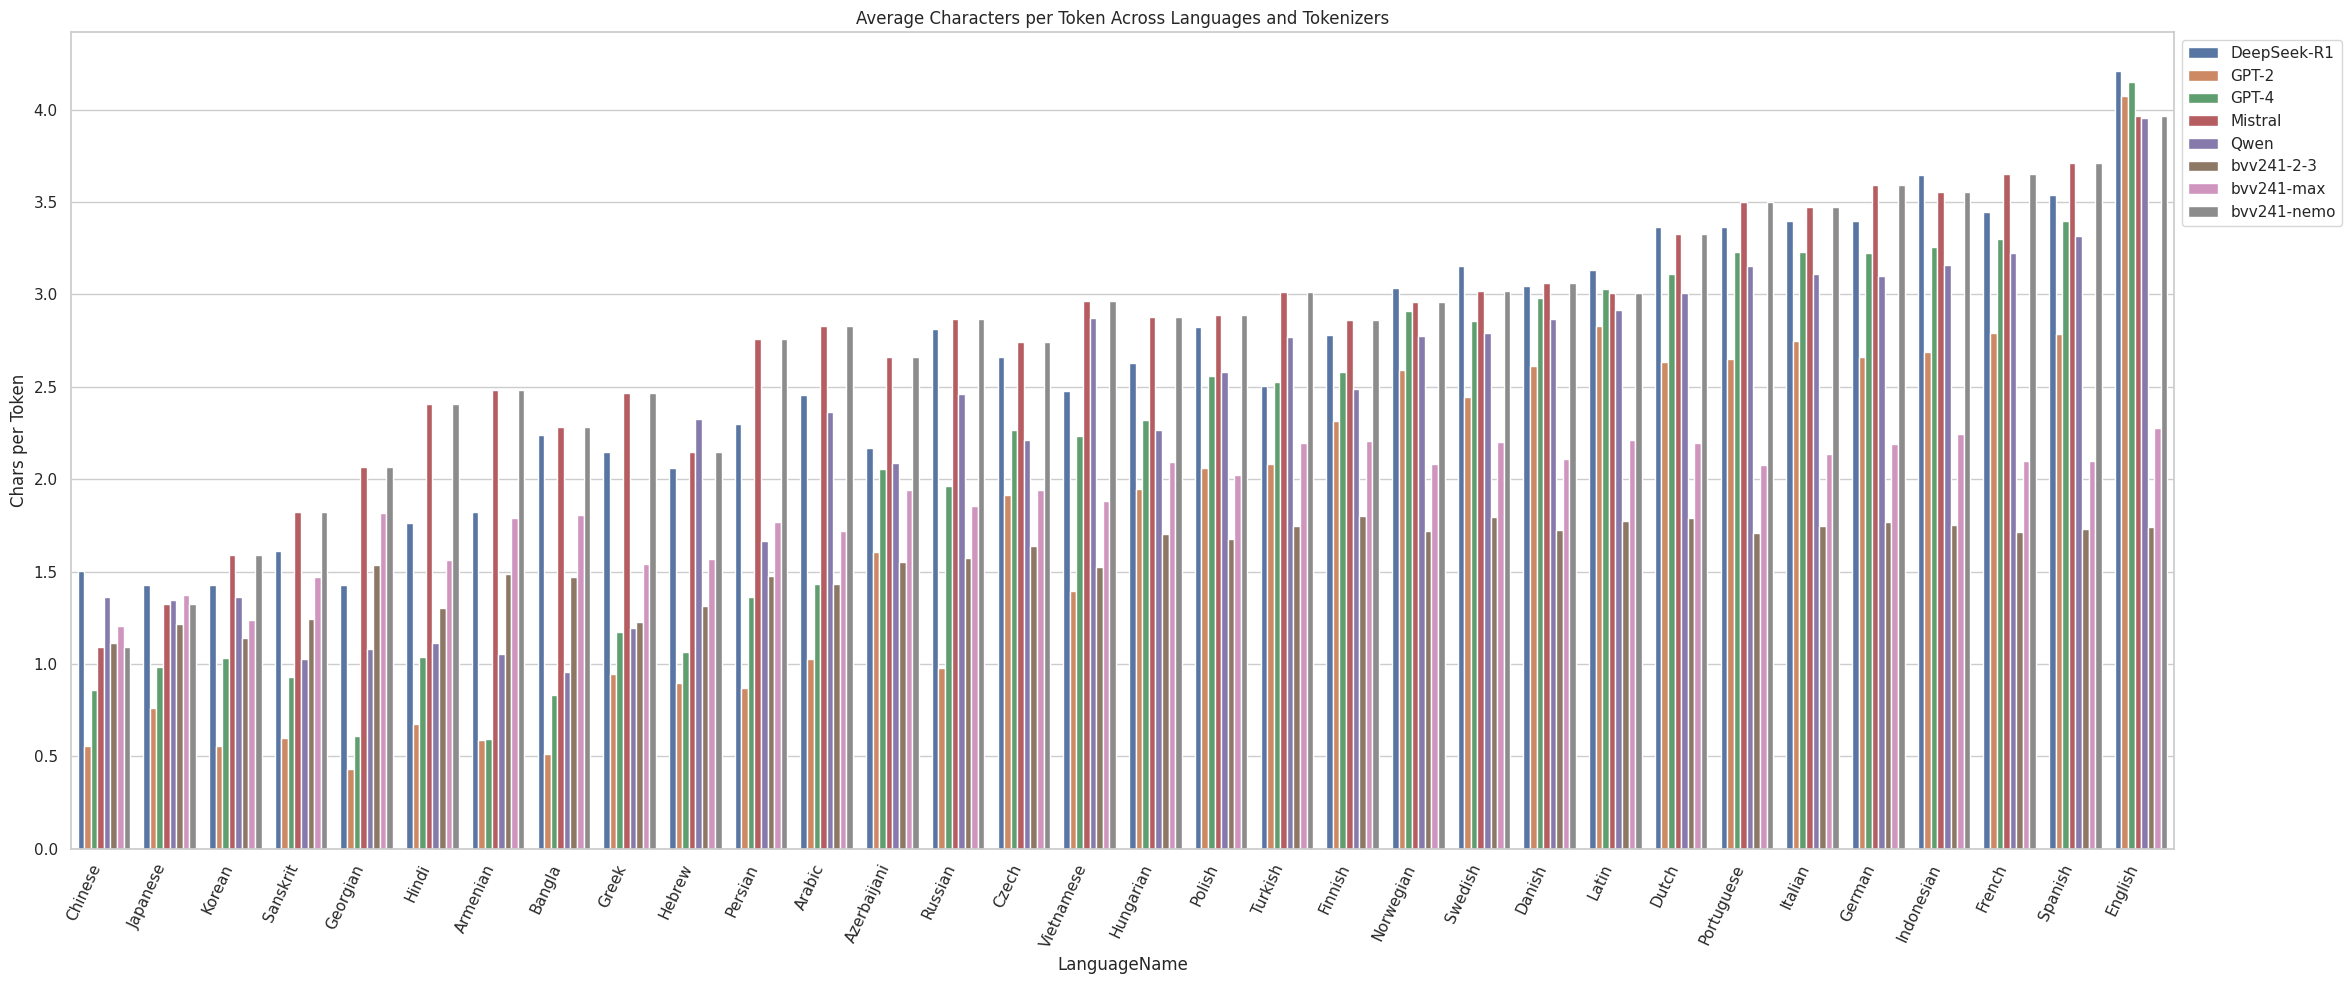

In [6]:
lang_order = df_pivot.mean(axis=1).sort_values().index

plt.figure(figsize=(22, 10))
sns.barplot(
    data=df_long, 
    x='LanguageName', y='Chars per Token', 
    hue='Tokenizer',
    order=lang_order
)
plt.xticks(rotation=65, ha='right')
plt.title('Average Characters per Token Across Languages and Tokenizers')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

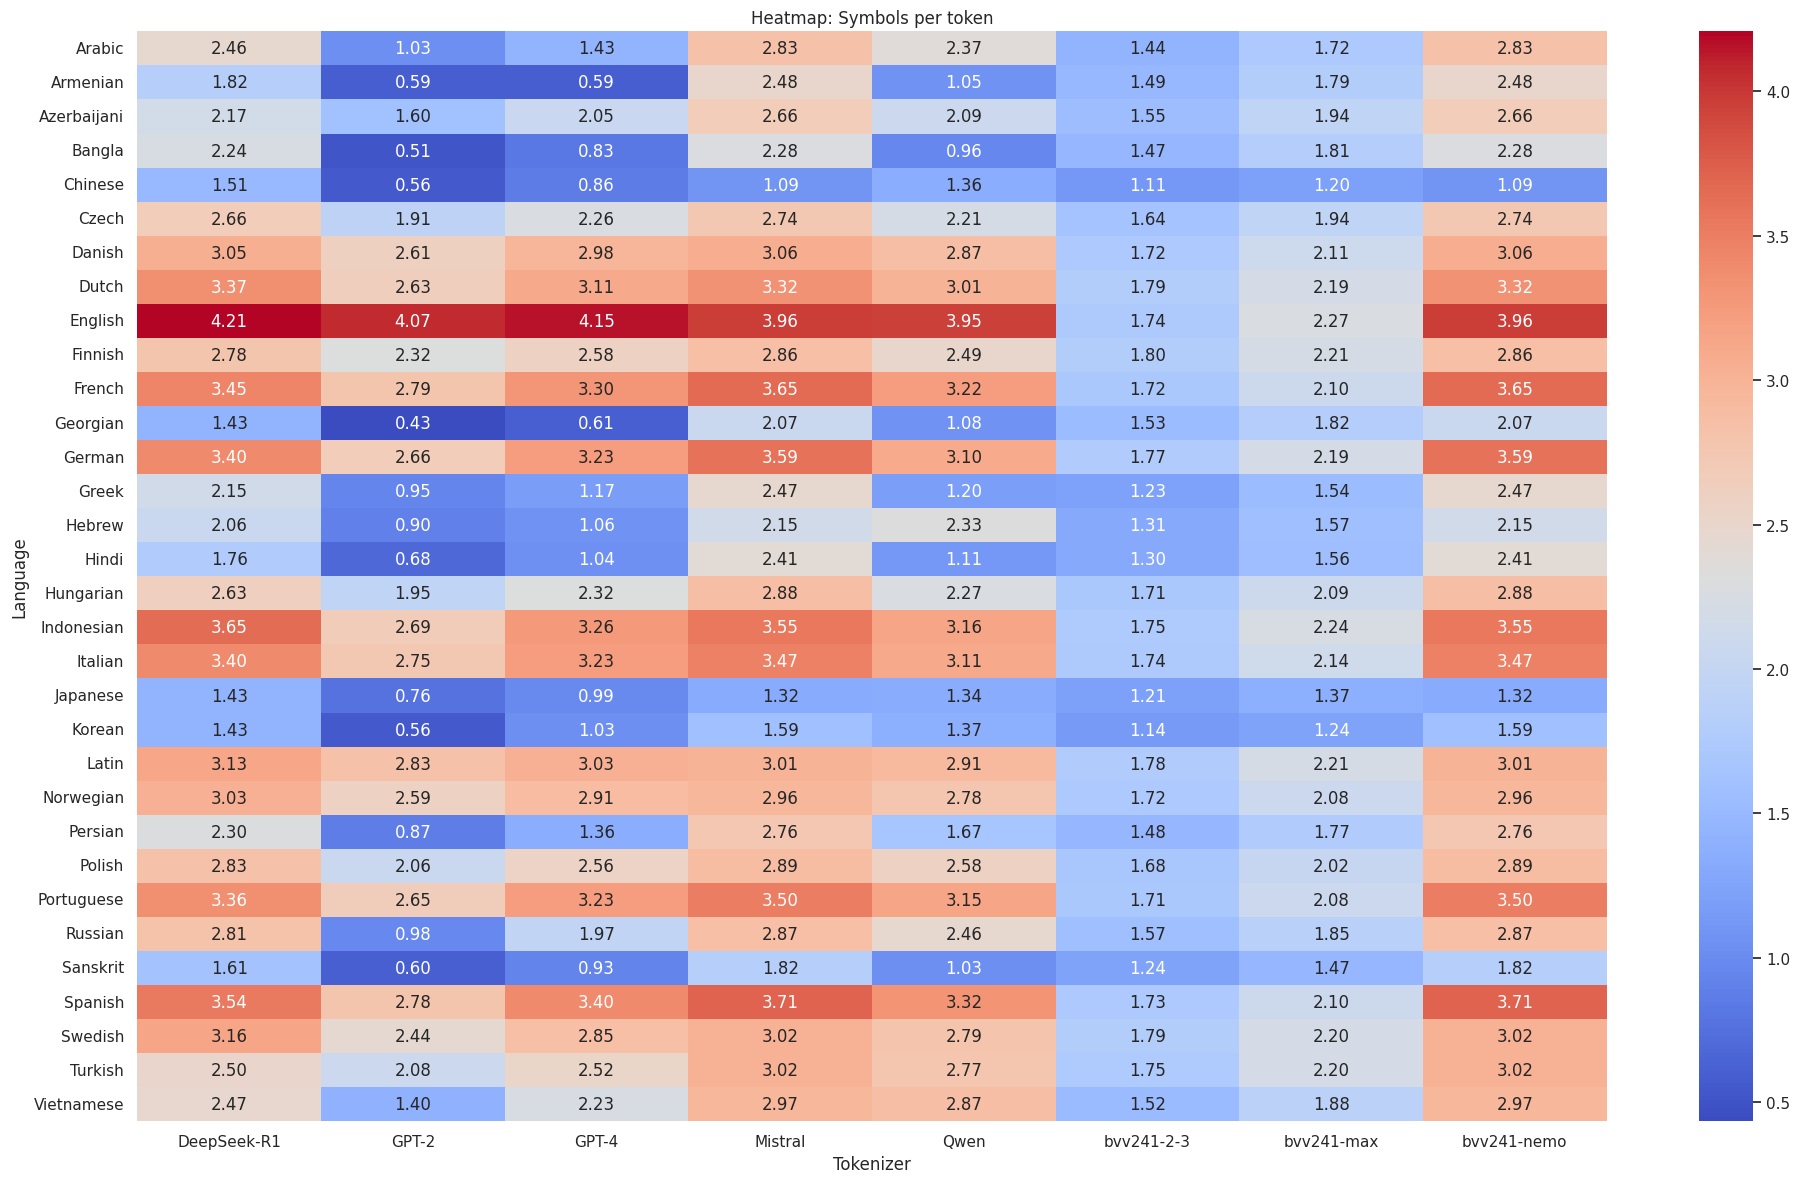

In [7]:
plt.figure(figsize=(20,12))
sns.heatmap(df_pivot[selected_tokenizers], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap: Symbols per token")
plt.ylabel("Language")
plt.xlabel("Tokenizer")
plt.tight_layout()
plt.show()

In [3]:
import torch

In [4]:
bvv241_nemo_tokenizer = AutoTokenizer.from_pretrained("Bochkov/bvv241-nemo")

In [5]:
original_sota_mistral_nemo_tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-Nemo-Instruct-2407')

In [6]:
from transformers import AutoModel, AutoModelForCausalLM

model_id = "mistralai/Mistral-Nemo-Instruct-2407"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cpu", 
    torch_dtype="auto", 
    trust_remote_code=True
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
original_sota_mistral_nemo_embeddings = model.model.embed_tokens.weight.data.cpu()

In [8]:
original_sota_mistral_nemo_embeddings.shape

torch.Size([131072, 5120])

In [9]:
from huggingface_hub import hf_hub_download
emb_path = hf_hub_download( repo_id="Bochkov/bvv241-nemo", filename="normalized_embeddings_weights.pt" )

bvv241_nemo_embeddings = torch.load(emb_path) 

In [10]:
bvv241_nemo_embeddings.shape

torch.Size([131072, 1024])

In [12]:
token_groups = {
    'animals':    ['cat', 'dog', 'fox', 'lion', 'mouse', 'rabbit', 'horse', 'rat'],
    'fruits':     ['apple', 'orange', 'pear'],
    'cities':     ['china', 'rome', 'rio'],
    'colors':     ['red', 'blue', 'green', 'yellow', 'black', 'white', 'orange', 'gray', 'gold'],
    'professions':['doctor', 'teacher', 'artist', 'writer', 'driver', 'chef'],
    'emotions':   ['anger', 'love', 'joy'],
    'digits':     ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'ten'],
    #'other': [
    #    'table', 'music', 'river', 'window', 'cloud', 'computer', 'game', 'movie', 'school',
    #    'letter', 'bridge', 'picture', 'train'
    #]
}

In [13]:
all_tokens = []
all_labels = []
group_colors = []
group_names = []

for group, words in token_groups.items():
    all_tokens.extend(words)
    all_labels.extend(words)
    group_colors.extend([group]*len(words))
    group_names.append(group)

In [14]:
token_ids = [original_sota_mistral_nemo_tokenizer.encode(t, add_special_tokens=False)[0] for t in all_tokens]
emb_selected = original_sota_mistral_nemo_embeddings[token_ids].to(torch.float32).numpy()  # shape [len(tokens), n_emb]
emb_selected.shape

(40, 5120)

In [15]:
token_ids_bvv241 = [bvv241_nemo_tokenizer.encode(t, add_special_tokens=False)[0] for t in all_tokens]
emb_selected_bvv241 = bvv241_nemo_embeddings[token_ids].to(torch.float32).numpy()  # shape [len(tokens), n_emb]
emb_selected_bvv241.shape

(40, 1024)

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [17]:
tsne = TSNE(n_components=2, random_state=0, perplexity=7)
emb_2d_tsne = tsne.fit_transform(emb_selected)

In [18]:
tsne_bvv241  = TSNE(n_components=2, random_state=0, perplexity=7)
emb_2d_tsne_bvv241 = tsne.fit_transform(emb_selected_bvv241)

In [19]:
import seaborn as sns
palette = sns.color_palette('hls', len(token_groups))
color_map = {group: palette[i] for i, group in enumerate(token_groups)}
colors = [color_map[g] for g in group_colors]

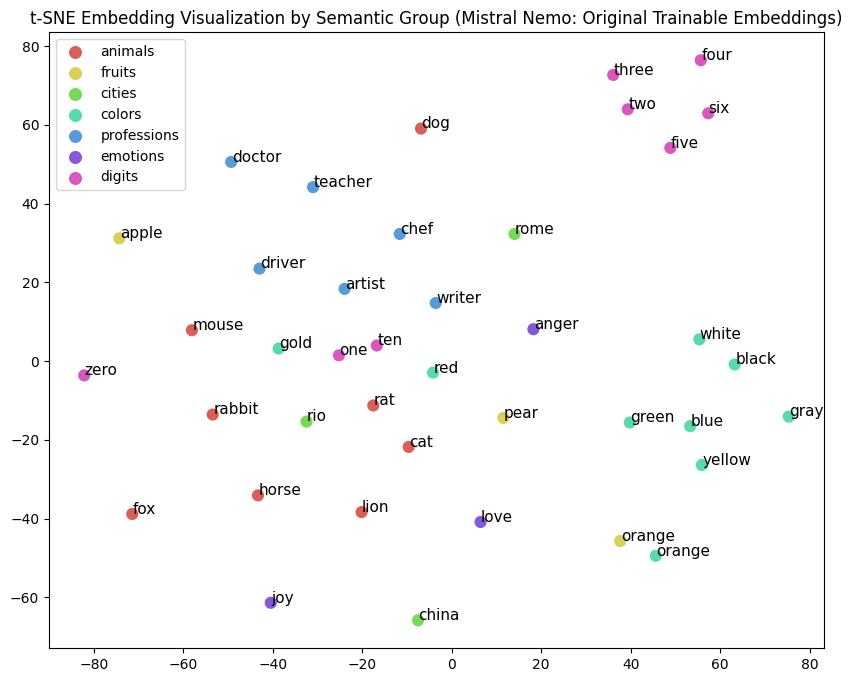

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(emb_2d_tsne[:,0], emb_2d_tsne[:,1], c=colors, s=60)
for i, label in enumerate(all_labels):
    plt.annotate(label, (emb_2d_tsne[i,0]+0.1, emb_2d_tsne[i,1]+0.05), fontsize=11)
for group, color in color_map.items():
    plt.scatter([], [], c=[color], label=group, s=70)
plt.legend()
plt.title('t-SNE Embedding Visualization by Semantic Group (Mistral Nemo: Original Trainable Embeddings)')
plt.show()

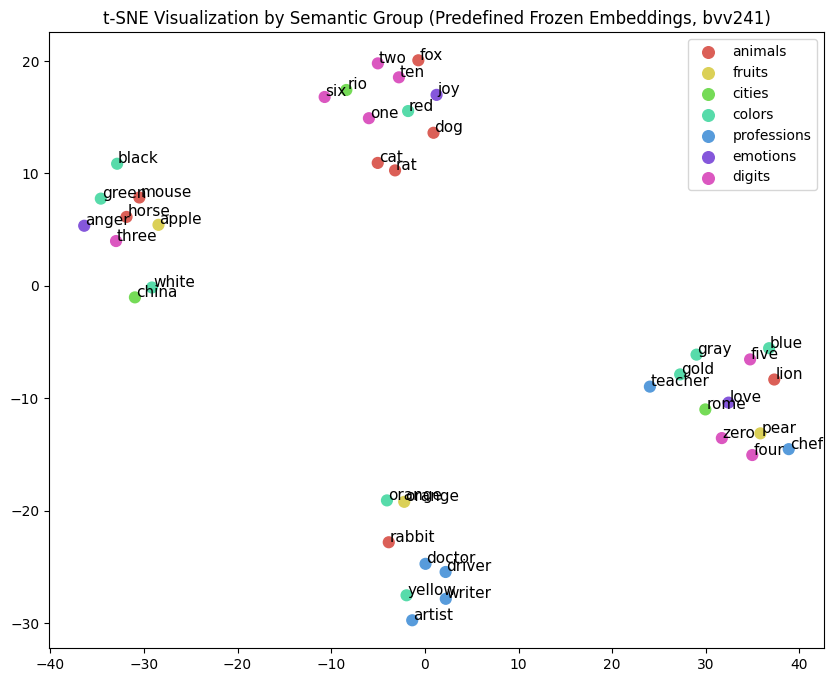

In [21]:
plt.figure(figsize=(10,8))
plt.scatter(emb_2d_tsne_bvv241[:,0], emb_2d_tsne_bvv241[:,1], c=colors, s=60)
for i, label in enumerate(all_labels):
    plt.annotate(label, (emb_2d_tsne_bvv241[i,0]+0.1, emb_2d_tsne_bvv241[i,1]+0.05), fontsize=11)
for group, color in color_map.items():
    plt.scatter([], [], c=[color], label=group, s=70)
plt.legend()
plt.title('t-SNE Visualization by Semantic Group (Predefined Frozen Embeddings, bvv241)')
plt.show()

Our fixed visual embedding vectors naturally cluster by surface/formal features (e.g., length), rather than by meaning. In contrast, trainable embeddings demonstrate soft semantic grouping, though the distributed latent space remains globally unstructured. This illustrates that any emergence of true semantic structure must occur entirely within the network’s compositional layers.

# Strengths of the bvv241* Tokenizer Family
## Transparent Unicode Mapping: 
Where possible, one Unicode codepoint maps directly to one token, resulting in maximally predictable tokenization across all languages.
Efficient Integration of Special Tokens: Unused and private Unicode ranges are systematically repurposed for custom and multi-character tokens, in contrast to the more chaotic allocation typical of BPE/Unigram.
Broad Language Coverage: Minimal token fragmentation is observed for rare and non-Latin scripts (e.g., Armenian, Georgian, Tibetan, ideographic systems).
## Multi-character Tokens from SOTA Models: 
Incorporation of ~19,000 multi-character tokens, derived from top-performing SOTA tokenizers, enables the compression of frequent substrings and words, reducing token counts in long texts while maintaining transparency.
# Weaknesses
## Less Aggressive Compression for Latin Scripts: 
In languages with short words and frequent morphemes (e.g., English, German, Spanish), traditional tokenizers (especially GPT-style BPEs) achieve stronger compression; as a result, bvv241* tokenizers produce 2x or more character per tokens for such languages.

# Analytical Perspective
A Unicode/character-oriented tokenizer is optimal for truly multilingual systems—as demonstrated by consistently low token inflation and minimal Unicode fragmentation for nearly all non-Latin scripts in the benchmarks.

In English and similar languages, these advantages become less significant: highly optimized Latin-centric BPEs (e.g., GPT-2/4) achieve stronger text compression, yielding tangible savings in memory and computation. However, for code-switched or multilingual datasets, symbol-based tokenization ensures robustness and reliability.

The inclusion of frequent multi-character tokens represents a beneficial compromise for diverse tasks, especially with numerous low-resource languages, ideographics, and emojis.

# Summary Recommendation:

A hybrid Unicode/character tokenizer as described here excels when the target model is truly multilingual (supporting many scripts), when predictable Unicode handling is desirable, or when compatibility with user input and special-symbol processing is critical. For fully English-centric tasks, classic BPE approaches remain more efficient.

# Final Conclusions
Combining strict Unicode mapping with multi-character tokens, the bvv241 family achieves highly stable performance for Asian, Arabic, and underrepresented scripts—where differences from SOTA are minimal.

For Indo-European (Latin and partially Cyrillic) languages, compression is less aggressive, but the model gains in predictability, recoverability, and linguistic inclusivity.

For general-purpose, multilingual applications, a high-frequency/hybrid character tokenizer of this type can surpass many current solutions in universality.

For highly English-focused tasks (e.g., pure Self-Instruct or similar), GPT-style BPE models still have an edge—but for mixed/multilingual semantic applications, this approach offers significant advantages.